In [ ]:
from IPython.display import clear_output

!pip install -U torch torchvision transformers
# !pip install ninja cmake wheel  # Обязательные для компиляции
!pip install ultralytics
!pip install colorthief
# !rm -rf /root/.cache/torch_extensions
clear_output()

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

# from ultralytics import YOLOWorld

import cv2
import matplotlib.pyplot as plt
import torch
from pathlib import Path
import os

# from colorthief import ColorThief
import pandas as pd
import sklearn


import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import timm
from torch.utils.data import Dataset, DataLoader

from PIL import Image, ImageDraw, ImageFont
import json

# from ultralytics import YOLO, YOLOWorld
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import math
from transformers import get_cosine_schedule_with_warmup
from torchmetrics.wrappers import ClasswiseWrapper
from torchmetrics import MetricCollection
import albumentations as A
from IPython.display import clear_output
import cv2
from tqdm import tqdm
from albumentations.pytorch import ToTensorV2
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
)
from pathlib import Path
from IPython.display import clear_output

In [ ]:
index_classname = {
    "chernyi": 4,
    "belyi": 0,
    "korichnevyi": 7,
    "raznocvetnyi": 10,
    "bezhevyi": 1,
    "sinii": 14,
    "rozovyi": 11,
    "seryi": 13,
    "zelenyi": 15,
    "krasnyi": 8,
    "goluboi": 6,
    "fioletovyi": 5,
    "bordovyi": 3,
    "zheltyi": 16,
    "oranzhevyi": 9,
    "serebristyi": 12,
    "zolotoi": 17,
    "biryuzovyi": 2,
}

In [14]:
data = pd.read_csv("/kaggle/input/purpel/dataset_colors/train_data.csv")

# SPLit

In [5]:
data["target"] = data["target"].map(index_classname)
train, val = train_test_split(
    data, test_size=0.15, random_state=42, stratify=data["target"]
)
train.to_csv("train_sp.csv", index=False)
val.to_csv("val_sp.csv", index=False)

## weights www

In [5]:
seet = pd.read_csv("/kaggle/working/train_sp.csv")
N = len(seet)
unique_classes = seet["target"].unique()
class_counts = seet["target"].value_counts().sort_index()
weights = N / (18 * class_counts)

# Downsample

In [58]:
class_counts = data["target"].value_counts()
min_count = class_counts.min()

df_downsampled = []

for target_class, group_data in data.groupby("target"):
    group_downsampled = group_data.sample(n=min_count, random_state=42)
    df_downsampled.append(group_downsampled)
df_downsampled = pd.concat(df_downsampled).reset_index(drop=True)
df_downsampled.to_csv("downsampled_data.csv", index=False)

In [60]:
data = pd.read_csv("/kaggle/working/downsampled_data.csv")

In [67]:
train, val = train_test_split(
    data, test_size=0.15, random_state=42, stratify=data["target"]
)
train["target"] = train["target"].map(index_classname)
val["target"] = val["target"].map(index_classname)
print(len(val), len(train))
train.to_csv("down_train.csv", index=False)
val.to_csv("down_val.csv", index=False)

95 535


# MOST POPULAR COLORS

In [88]:
train, val = train_test_split(
    data, test_size=0.06, random_state=42, stratify=data["target"]
)
val["target"] = val["target"].map(index_classname)
norm = [
    "chernyi",
    "belyi",
    "korichnevyi",
    "raznocvetnyi",
    "bezhevyi",
    "sinii",
    "rozovyi",
    "seryi",
    "zelenyi",
]

In [44]:
data_somecolors = train[train["target"].isin(norm)]
data_somecolors["target"] = data_somecolors["target"].map(index_classname)
print(len(train), len(data_somecolors))

31304 27608


<ipython-input-44-fc626346bd17>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_somecolors['target'] = data_somecolors['target'].map(index_classname)


In [45]:
train, test = train_test_split(
    data_somecolors, test_size=0.18, random_state=42, stratify=data_somecolors["target"]
)

print(len(train), len(test), len(val))
train.to_csv("train_somecolors.csv", index=False)
test.to_csv("test_somecolors.csv", index=False)
val.to_csv("val_somecolors.csv", index=False)

22638 4970 1999


# Dataset

In [48]:
def train_transforms(probs=0.5):
    return A.Compose(
        [
            A.Resize(256, 256),
            A.OneOf(
                [
                    A.HorizontalFlip(p=1),
                    A.VerticalFlip(p=1),
                ],
                p=probs,
            ),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.5
            ),
            A.RandomGamma(gamma_limit=(40, 100), p=0.5),
            A.RandomBrightnessContrast(
                brightness_limit=(0, 0.3),
                contrast_limit=(0, 0.3),
                brightness_by_max=True,
                ensure_safe_range=False,
                p=0.5,
            ),
            # A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            A.Normalize(),
            ToTensorV2(),
        ]
    )


def val_transform():
    return A.Compose([A.Resize(256, 256), A.Normalize(), ToTensorV2()])


class TorchDataset(Dataset):
    def __init__(self, csv_file, img_dir, mode="train"):
        self.images = []
        self.img_dir = img_dir
        self.mode = mode
        self.__read_csv(csv_file)
        self.__init_transforms(aug_prob=0.5)

    def __read_csv(self, csv_file):
        with open(csv_file, "r") as file:
            for i, line in enumerate(file.readlines()):
                if i == 0:
                    continue
                image, _, label = line.strip().split(",")
                self.images.append([image, int(label)])

    def __init_transforms(self, aug_prob):
        self.transforms = (
            train_transforms(aug_prob) if self.mode == "train" else val_transform()
        )

    def __len__(self):
        return len(self.images)

    def load_sample(self, idx):
        image_path, label = self.images[idx]

        if not os.path.exists(os.path.join(self.img_dir, image_path + ".jpg")):
            raise ValueError(f"{os.path.join(self.img_dir, image_path)} doesn't exist")
        image = cv2.imread(os.path.join(self.img_dir, image_path + ".jpg"))
        return image, label

    def __getitem__(self, idx):
        image, label = self.load_sample(idx)
        if self.transforms is not None:
            image = self.transforms(image=image)["image"]
        return image, torch.as_tensor(label)


def make_loader(csv_file, img_dir, mode="train"):
    dataset = TorchDataset(csv_file, img_dir, mode=mode)
    dataloader = DataLoader(
        dataset, shuffle=(mode == "train"), batch_size=128, num_workers=8
    )
    return dataloader, dataset

In [49]:
train_loader, train_dataset = make_loader(
    "/kaggle/working/train_sp.csv",
    "/kaggle/input/purpel/dataset_colors/train_data",
    mode="train",
)
# test_loader, test_dataset = make_loader(
#     '/kaggle/working/test_somecolors.csv',
#     '/kaggle/input/purpel/dataset_colors/train_data',
#     mode='test',
#     )
val_loader, val_dataset = make_loader(
    "/kaggle/working/val_sp.csv",
    "/kaggle/input/purpel/dataset_colors/train_data",
    mode="val",
)

<ipython-input-48-7174f4b5e07a>:17: UserWarning: Argument 'ensure_safe_range' is not valid and will be ignored.
  A.RandomBrightnessContrast(brightness_limit=(0, 0.3), contrast_limit=(0, 0.3), brightness_by_max=True, ensure_safe_range=False, p=0.5),


# MODELS

In [50]:
class TorchModel(nn.Module):
    def __init__(self, encoder, output):
        super(TorchModel, self).__init__()
        self.model = timm.create_model(encoder, pretrained=True, num_classes=output)

        for param in self.model.patch_embed.parameters():
            param.requires_grad = False
        for param in self.model.blocks[:20].parameters():
            param.requires_grad = False
        # # for param in self.model.stages[:3].parameters():
        # #     param.requires_grad = False
        # # for param in self.model.stages[3][0].parameters():
        # #     param.requires_grad = False

    def forward(self, x):
        return self.model(x)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
class TinyConvNet(nn.Module):
    def __init__(self, num_classes):
        super(TinyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.fc = nn.Linear(64 * 28 * 28, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [52]:
# model = TorchModel("resnet34", 18)
model = TorchModel("vit_mediumd_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k", 18)

# Общее количество параметров:
total_params = sum(p.numel() for p in model.parameters())

# Количество замороженных (необучаемых) параметров:
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

# Количество обучаемых параметров:
trainable_params = total_params - frozen_params

print("Всего параметров:", total_params)
print("Замороженных параметров:", frozen_params)
print("Обучаемых параметров:", trainable_params)

model.safetensors:   0%|          | 0.00/256M [00:00<?, ?B/s]

Всего параметров: 63605266
Замороженных параметров: 63461888
Обучаемых параметров: 143378


## Train Loop


Epoch 20/20 - Train Loss: 0.7603
Train multiclassaccuracy_belyi: 0.7381086945533752
Train multiclassaccuracy_bezhevyi: 0.45006483793258667
Train multiclassaccuracy_biryuzovyi: 0.10000000149011612
Train multiclassaccuracy_bordovyi: 0.3735498785972595
Train multiclassaccuracy_chernyi: 0.8460959792137146
Train multiclassaccuracy_fioletovyi: 0.47999998927116394
Train multiclassaccuracy_goluboi: 0.3997175097465515
Train multiclassaccuracy_korichnevyi: 0.6074975728988647
Train multiclassaccuracy_krasnyi: 0.5946969985961914
Train multiclassaccuracy_oranzhevyi: 0.2857142984867096
Train multiclassaccuracy_raznocvetnyi: 0.5965617895126343
Train multiclassaccuracy_rozovyi: 0.597322940826416
Train multiclassaccuracy_serebristyi: 0.1147540956735611
Train multiclassaccuracy_seryi: 0.29891955852508545
Train multiclassaccuracy_sinii: 0.6500920653343201
Train multiclassaccuracy_zelenyi: 0.5720081329345703
Train multiclassaccuracy_zheltyi: 0.5597667694091797
Train multiclassaccuracy_zolotoi: 0.0
Train m

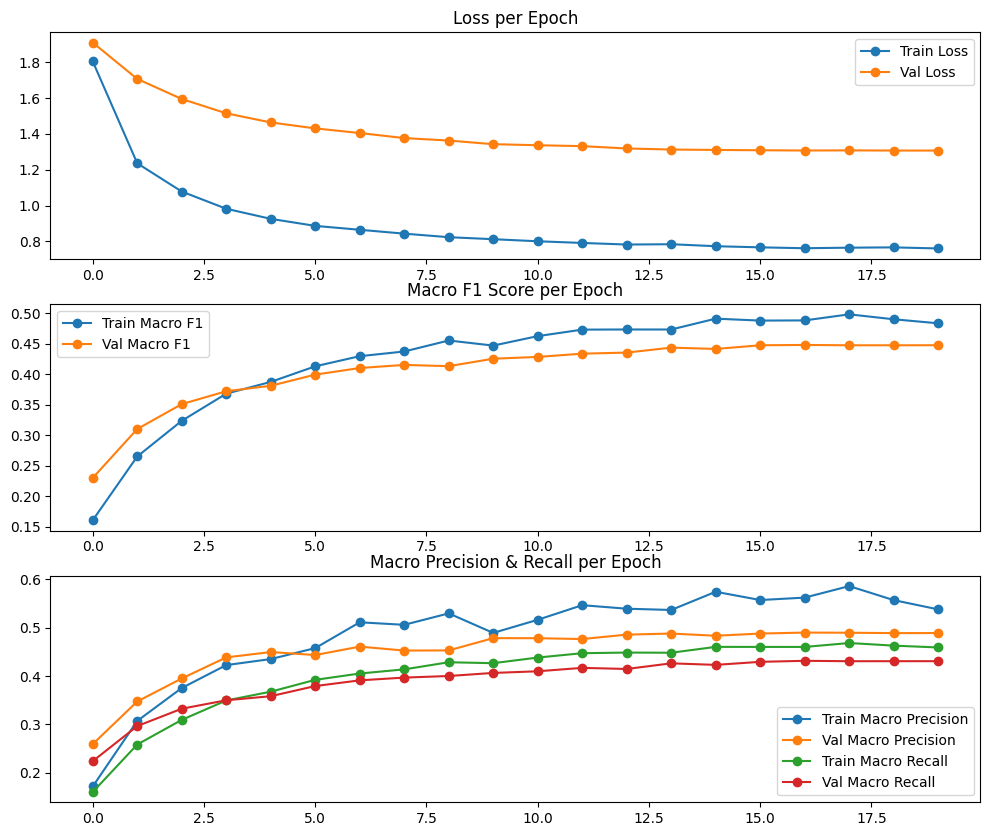

<Figure size 640x480 with 0 Axes>

In [53]:
def train_model(train_loader, val_loader, num_epochs=20):
    encoder = "vit_mediumd_patch16_reg4_gap_256.sbb2_e200_in12k_ft_in1k"
    save_path = os.path.join("./exp", encoder + "coef_loss_full")
    os.makedirs(save_path, exist_ok=True)
    labels = [
        "belyi",
        "bezhevyi",
        "biryuzovyi",
        "bordovyi",
        "chernyi",
        "fioletovyi",
        "goluboi",
        "korichnevyi",
        "krasnyi",
        "oranzhevyi",
        "raznocvetnyi",
        "rozovyi",
        "serebristyi",
        "seryi",
        "sinii",
        "zelenyi",
        "zheltyi",
        "zolotoi",
    ]
    index_classname_similar = {
        4: [4, 13, 7, 3],
        0: [0, 1, 12, 11],
        7: [7, 4, 9, 17],
        10: [10],
        1: [1, 0, 17, 12],
        14: [14, 6, 5, 2],
        11: [11, 8, 0, 5],
        13: [13, 4, 12, 6],
        15: [15, 2, 16],
        8: [8, 3, 9, 11],
        6: [6, 14, 12, 2],
        5: [5, 14, 11, 3],
        3: [3, 8, 4, 5],
        16: [16, 9, 17, 15],
        9: [9, 8, 16, 7],
        12: [12, 13, 0, 6],
        17: [17, 16, 1, 7],
        2: [2, 14, 6, 15],
    }
    similar_coeff = 0.05
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TorchModel(encoder, 18)
    if torch.cuda.device_count() > 1:
        print("Используем", torch.cuda.device_count(), "GPU")
        model = nn.DataParallel(model)
    model.to(device)
    # weights_tensor = torch.tensor(weights.values, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(reduction="none")

    train_metrics = MetricCollection(
        {
            "multiclassAccuracy": ClasswiseWrapper(
                MulticlassAccuracy(num_classes=18, average=None), labels=labels
            ),
            "multiclassPrecision": ClasswiseWrapper(
                MulticlassPrecision(num_classes=18, average=None), labels=labels
            ),
            "multiclassRecall": ClasswiseWrapper(
                MulticlassRecall(num_classes=18, average=None), labels=labels
            ),
            "multiclassF1score": ClasswiseWrapper(
                MulticlassF1Score(num_classes=18, average=None), labels=labels
            ),
            "multiclassF1scoreMacro": MulticlassF1Score(
                num_classes=18, average="macro"
            ),
            "multiclassPrecision_macro": MulticlassPrecision(
                num_classes=18, average="macro"
            ),
            "multiclassRecall_macro": MulticlassRecall(num_classes=18, average="macro"),
        }
    ).to(device)

    val_metrics = MetricCollection(
        {
            "multiclassAccuracy": ClasswiseWrapper(
                MulticlassAccuracy(num_classes=18, average=None), labels=labels
            ),
            "multiclassPrecision": ClasswiseWrapper(
                MulticlassPrecision(num_classes=18, average=None), labels=labels
            ),
            "multiclassRecall": ClasswiseWrapper(
                MulticlassRecall(num_classes=18, average=None), labels=labels
            ),
            "multiclassF1score": ClasswiseWrapper(
                MulticlassF1Score(num_classes=18, average=None), labels=labels
            ),
            "multiclassF1scoreMacro": MulticlassF1Score(
                num_classes=18, average="macro"
            ),
            "multiclassPrecision_macro": MulticlassPrecision(
                num_classes=18, average="macro"
            ),
            "multiclassRecall_macro": MulticlassRecall(num_classes=18, average="macro"),
            "multiclassAccuracy_macro": MulticlassAccuracy(
                num_classes=18, average="macro"
            ),
        }
    ).to(device)

    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=0.0002,
        weight_decay=0.0001,
    )  # бубугага

    num_training_steps = math.ceil(len(train_loader) / 1)  #  2
    total_steps = num_training_steps * num_epochs
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    train_loss_history = []
    val_loss_history = []
    train_macroF1_history = []
    val_macroF1_history = []
    train_macroPrecision_history = []
    val_macroPrecision_history = []
    train_macroRecall_history = []
    val_macroRecall_history = []

    best_pr_macro = -float("inf")
    plt.ion()

    for epoch in range(num_epochs):
        model.train()
        train_metrics.reset()
        epoch_train_loss = 0.0
        train_samples = 0

        pbar = tqdm(
            train_loader, desc=f"Train Epoch {epoch+1}/{num_epochs}", leave=False
        )
        for batch in pbar:
            x, y = batch
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            outputs = model(x)
            losses = criterion(outputs, y)
            preds = outputs.argmax(dim=1)

            multipliers = torch.ones_like(losses, dtype=torch.float32)
            for i in range(len(y)):
                pred = preds[i].item()
                target = y[i].item()
                if target in index_classname_similar.get(pred, []):
                    multipliers[i] = similar_coeff

            loss = (losses * multipliers.to(losses.device)).mean()

            loss.backward()
            optimizer.step()
            scheduler.step()

            epoch_train_loss += loss.item() * x.size(0)
            train_samples += x.size(0)

            train_metrics.update(preds, y)

        avg_train_loss = epoch_train_loss / train_samples
        train_values = train_metrics.compute()

        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}")
        for metric_name, value in train_values.items():
            print(f"Train {metric_name}: {value}")

        model.eval()
        val_metrics.reset()
        epoch_val_loss = 0.0
        val_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                x, y = batch
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y).mean()
                epoch_val_loss += loss.item() * x.size(0)
                val_samples += x.size(0)

                preds = outputs.argmax(dim=1)
                val_metrics.update(preds, y)

        avg_val_loss = epoch_val_loss / val_samples
        val_values = val_metrics.compute()

        print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {avg_val_loss:.4f}")
        for metric_name, value in val_values.items():
            print(f"Val {metric_name}: {value}")

        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)

        train_macroF1 = train_values.get("multiclassF1scoreMacro")
        val_macroF1 = val_values.get("multiclassF1scoreMacro")
        train_macroPrecision = train_values.get("multiclassPrecision_macro")
        val_macroPrecision = val_values.get("multiclassPrecision_macro")
        train_macroRecall = train_values.get("multiclassRecall_macro")
        val_macroRecall = val_values.get("multiclassRecall_macro")

        train_macroF1 = (
            train_macroF1.item()
            if isinstance(train_macroF1, torch.Tensor)
            else train_macroF1
        )
        val_macroF1 = (
            val_macroF1.item() if isinstance(val_macroF1, torch.Tensor) else val_macroF1
        )
        train_macroPrecision = (
            train_macroPrecision.item()
            if isinstance(train_macroPrecision, torch.Tensor)
            else train_macroPrecision
        )
        val_macroPrecision = (
            val_macroPrecision.item()
            if isinstance(val_macroPrecision, torch.Tensor)
            else val_macroPrecision
        )
        train_macroRecall = (
            train_macroRecall.item()
            if isinstance(train_macroRecall, torch.Tensor)
            else train_macroRecall
        )
        val_macroRecall = (
            val_macroRecall.item()
            if isinstance(val_macroRecall, torch.Tensor)
            else val_macroRecall
        )

        if val_macroF1 > best_pr_macro:
            best_pr_macro = val_macroF1
            torch.save(
                model.state_dict(),
                os.path.join(
                    save_path, f"bestmodel_macrof1:{val_macroF1}_epoch:{epoch+1}.pth"
                ),
            )

        train_macroF1_history.append(train_macroF1)
        val_macroF1_history.append(val_macroF1)
        train_macroPrecision_history.append(train_macroPrecision)
        val_macroPrecision_history.append(val_macroPrecision)
        train_macroRecall_history.append(train_macroRecall)
        val_macroRecall_history.append(val_macroRecall)

        plt.figure(1)
        plt.gcf().set_size_inches(12, 10)
        plt.clf()

        plt.subplot(3, 1, 1)
        plt.plot(train_loss_history, label="Train Loss", marker="o")
        plt.plot(val_loss_history, label="Val Loss", marker="o")
        plt.legend()
        plt.title("Loss per Epoch")

        plt.subplot(3, 1, 2)
        plt.plot(train_macroF1_history, label="Train Macro F1", marker="o")
        plt.plot(val_macroF1_history, label="Val Macro F1", marker="o")
        plt.legend()
        plt.title("Macro F1 Score per Epoch")

        plt.subplot(3, 1, 3)
        plt.plot(
            train_macroPrecision_history, label="Train Macro Precision", marker="o"
        )
        plt.plot(val_macroPrecision_history, label="Val Macro Precision", marker="o")
        plt.plot(train_macroRecall_history, label="Train Macro Recall", marker="o")
        plt.plot(val_macroRecall_history, label="Val Macro Recall", marker="o")
        plt.legend()
        plt.title("Macro Precision & Recall per Epoch")

        plt.pause(0.01)
        plt.draw()

        # torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}.pth")

    torch.save(model.state_dict(), os.path.join(save_path, "model_final.pth"))
    plt.savefig(os.path.join(save_path, "loss.png"))
    plt.ioff()
    plt.show()


train_model(train_loader=train_loader, val_loader=val_loader)

In [ ]:
def test_model(test_loader, weight_path):
    labels = [
        "belyi",
        "bezhevyi",
        "biryuzovyi",
        "bordovyi",
        "chernyi",
        "fioletovyi",
        "goluboi",
        "korichnevyi",
        "krasnyi",
        "oranzhevyi",
        "raznocvetnyi",
        "rozovyi",
        "serebristyi",
        "seryi",
        "sinii",
        "zelenyi",
        "zheltyi",
        "zolotoi",
    ]

    device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

    # Создаем модель и загружаем веса
    model = TorchModel("resnext26ts", 18).to(device)
    state_dict = torch.load(weight_path, map_location=device)
    model.load_state_dict(state_dict, strict=True)

    test_metrics = MetricCollection(
        {
            "multiclassPrecision": ClasswiseWrapper(
                MulticlassPrecision(num_classes=18, average=None), labels=labels
            ),
            "multiclassRecall": ClasswiseWrapper(
                MulticlassRecall(num_classes=18, average=None), labels=labels
            ),
            "multiclassF1score": ClasswiseWrapper(
                MulticlassF1Score(num_classes=18, average=None), labels=labels
            ),
            "multiclassAccuracy": ClasswiseWrapper(
                MulticlassAccuracy(num_classes=18, average=None), labels=labels
            ),
            "multiclassPrecision_macro": MulticlassPrecision(
                num_classes=18, average="macro"
            ),
            "multiclassRecall_macro": MulticlassRecall(num_classes=18, average="macro"),
            "multiclassF1score_macro": MulticlassF1Score(
                num_classes=18, average="macro"
            ),
            "multiclassAccuracy_macro": MulticlassAccuracy(
                num_classes=18, average="macro"
            ),
        }
    ).to(device)
    test_metrics.reset()

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            test_metrics.update(preds, y)

    test_values = test_metrics.compute()

    data = [(k, v.item()) for k, v in test_values.items()]

    # Создаем DataFrame
    df = pd.DataFrame(data, columns=["metric", "value"])

    name = weight_path.split("/")[-2]
    df.to_csv(os.path.join("./exp", name, "torch_metrics.csv"), index=False)

    print("Test Metrics:")
    for metric_name, value in test_values.items():
        print(f"{metric_name}: {value}")
    return


test_model(
    test_loader=test_loader,
    weight_path="/storage_research/pavel.smirnov/Projects/probnik/purple/exp/resnext26tsmore augs/bestmodel.pth",
)

In [ ]:
# Проверка доступности CUDA
print(f"PyTorch CUDA доступен: {torch.cuda.is_available()}")
print(f"Версия CUDA: {torch.version.cuda}")

# Загрузка модели
model_id = "IDEA-Research/grounding-dino-tiny"

try:
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to("cuda")
    print("Модель успешно загружена на GPU!")
except Exception as e:
    print(f"Ошибка: {e}")
    print("Пытаюсь загрузить на CPU...")
    processor = AutoProcessor.from_pretrained(model_id)
    model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).cpu()

In [ ]:
image = cv2.imread("/kaggle/input/purpel/dataset_colors/train_data/36472599540.jpg")
print(image.shape)
# Check for cats and remote controls

text_labels = ["bag", "table", "chair", "clothes"]

inputs = processor(images=image, text=text_labels, return_tensors="pt").to("cuda")

with torch.no_grad():

    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[image.shape[::-1]],
)

# Retrieve the first image result

result = results[0]

In [ ]:
image = cv2.imread("/kaggle/input/purpel/dataset_colors/train_data/36477335632.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

text_labels = ["handbag", "table", "chair", "woman clothes"]

inputs = processor(images=image, text=text_labels, return_tensors="pt").to("cuda")

with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.3,
    target_sizes=[(image.shape[0], image.shape[1])],
)

result = results[0]
print(result["scores"], result["boxes"], result["labels"])
if len(result["boxes"]) > 0:
    image_with_boxes = image.copy()
    confidence_threshold = 0.4
    for idx, (box, score) in enumerate(zip(result["boxes"], result["scores"])):
        if score < confidence_threshold:
            continue
        box = box.cpu().numpy()
        xmin, ymin, xmax, ymax = map(int, box)
        cv2.rectangle(
            img=image_with_boxes,
            pt1=(xmin, ymin),
            pt2=(xmax, ymax),
            color=(255, 0, 0),
            thickness=2,
        )

    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes)
    plt.axis("off")
    plt.show()

In [ ]:
from PIL import Image
import torchvision.transforms as T

In [ ]:
model = YOLOWorld("yolov8l-worldv2.pt").to("cuda")

model.set_classes(
    [
        "kids clothes(female)" "female clothes",
        "woman clothes",
        # 'kids pants(female)',
        # 'kids jacket(female)'
        # 'girls outfits',
        # 'female children clothing',
        # 'young girls garments',
        # 'tween girls fashion',
        # 'girls wardrobe',
        # 'girls attire',
        # 'teen girls clothing',
        # 'girls wear',
        # 'kids pants (female)',
        # 'kids clothes(female)',
        # 'kids shirt (female)',
        # # 'girls clothing line',
        # 'girls fashionwear',
        # 'girls daily wear',
        # 'girls casual attire',
        # 'girls formal garments',
    ]
)

results = model.predict(
    "/kaggle/input/purpel/dataset_colors/train_data/29629862402.jpg", device="cuda"
)

results[0].show()

In [ ]:
Path("/kaggle/input/purpel/dataset_colors/test_data/19564221134.png").stem

In [ ]:
model = YOLOWorld("yolov8l-worldv2.pt").to("cuda")
DATA_DIR = "/kaggle/input/purpel/dataset_colors/train_data"
DATA_CSV = pd.read_csv("/kaggle/input/purpel/dataset_colors/train_data.csv")
categories = {
    "столы": ["table"],
    "стулья": ["chair"],
    "сумки": ["suitcase", "backpack", "bag", "handbag"],
    "одежда для девочек": [
        "kids clothes(female)",
        "female clothes",
        "woman clothes",
    ],
}
for filename in os.listdir(DATA_DIR):
    img_path = os.path.join(DATA_DIR, filename)
    img_name = Path(img_path).stem
    category = DATA_CSV.loc[DATA_CSV["id"] == int(img_name)]["category"].item()
    model.set_classes(categories[category])
    results = model.predict(img_path)

    output_dir = Path("Cropped_images")
    output_dir.mkdir(exist_ok=True)

    image = cv2.imread(img_path)
    for i, coords in enumerate(results[0].boxes.data):
        coords = coords.cpu().numpy()
        x_min = int(coords[0])
        y_min = int(coords[1])
        x_max = int(coords[2])
        y_max = int(coords[3])
        cropped = image[y_min:y_max, x_min:x_max]
        dir_save = output_dir / str(img_name)
        dir_save.mkdir(exist_ok=True)
        cv2.imwrite(
            str(dir_save / f"crop_{i}.jpg"), cv2.cvtColor(cropped, cv2.COLOR_RGB2BGR)
        )